# 🥚🍳 Broken Egg Classification: Dataset Analysis and Model Training 🍳🥚
## 0. Introduction

### Prologue
This project focuses on classifying broken eggs using machine learning models to enhance accuracy over traditional human methods. By preprocessing images and applying various algorithms, including K-Nearest Neighbors, Logistic Regression, Decision Tree, and Random Forest, we achieved significant performance improvements. Future work will involve expanding the dataset and exploring deep learning techniques for better recognition.

### Dataset Overview
This dataset comprises 369 images, each with dimensions of 960 x 720 pixels, depicting eggs. The images are categorized into "good" and "cracked" within both the "test" and "train" directories. The "cracked" eggs exhibit varying degrees of damage, ranging from minor scratches to being completely destroyed. Additionally, there are images labeled as "empty," which we have chosen to exclude from our analysis.

You can get the dataset here - https://www.kaggle.com/datasets/frankpereny/broken-eggs

## 1. Importing Libraries and Define Functions
### 1.1 Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patheffects import withSimplePatchShadow
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

%matplotlib inline

### 1.2. Define Functions for Data Loading and Preprocessing

In [2]:
# Function to shuffle images and labels
def shuffle_images_and_labels(images, labels):
    # Create a permutation of indices
    permutation = np.random.permutation(len(images))
    
    # Shuffle the images and labels
    shuffled_images = images[permutation]
    shuffled_labels = labels[permutation]
    
    return shuffled_images, shuffled_labels

In [3]:
def load_images_from_directory(directory):
    """
    Load images and corresponding labels from a specified directory.

    This function traverses through subdirectories named 'good' and 'crack' within the given directory,
    reads the images, and assigns appropriate labels to each image. The 'good' images are labeled as 0,
    and the 'crack' images are labeled as 1.

    Parameters:
    directory (str): The path to the directory containing the subdirectories 'good' and 'crack'.

    Returns:
    tuple: A tuple containing two numpy arrays:
        - images (np.ndarray): Array of loaded images.
        - labels (np.ndarray): Array of corresponding labels.
    """
    images = []
    labels = []
    for label, subdir in enumerate(['good', 'crack']):
        subdir_path = os.path.join(directory, subdir)
        for filename in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, filename)
            image = cv2.imread(file_path)
            if image is not None:
                images.append(image)
                labels.append(label)
                
    return shuffle_images_and_labels(np.array(images), np.array(labels))

In [4]:
def visualize_label_distribution(y_train, y_test):
    """
    Visualize the distribution of labels in the training and test datasets.

    This function creates pie charts to illustrate the proportion of 'good' and 'cracked' eggs
    in both the training and test datasets. It uses custom colors, styles the labels and percentages,
    and adds a shadow effect to the pie charts for better visualization.

    Parameters:
    y_train (np.ndarray): Array of labels for the training dataset.
    y_test (np.ndarray): Array of labels for the test dataset.

    Returns:
    None
    """
    labels = ['Good', 'Crack']
    y_train_counts = np.bincount(y_train)
    y_test_counts = np.bincount(y_test)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

    # Define custom colors
    colors = ['#4CAF50', '#FF5722']
    
    # Define explode values to separate the slices
    explode = (0.05, 0.05)

    # Training set pie chart
    wedges, texts, autotexts = axes[0].pie(y_train_counts, labels=labels, autopct='%1.1f%%', startangle=90, 
                                           colors=colors, explode=explode, textprops={'fontsize': 12}, 
                                           wedgeprops={'linewidth': 1, 'edgecolor': 'white',
                                                       'linestyle': 'solid', 'antialiased': True})
    axes[0].set_title('Training Set Label Distribution', fontsize=14, fontweight='bold')

    # Style the labels and percentages
    for text in texts:
        text.set_color('#333333')
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')

    # Add shadow effect to the pie chart
    for wedge in wedges:
        wedge.set_path_effects([withSimplePatchShadow()])

    # Test set pie chart
    wedges, texts, autotexts = axes[1].pie(y_test_counts, labels=labels, autopct='%1.1f%%', startangle=90, 
                                           colors=colors, explode=explode, textprops={'fontsize': 12}, 
                                           wedgeprops={'linewidth': 1, 'edgecolor': 'white', 'linestyle': 'solid',
                                                       'antialiased': True})
    axes[1].set_title('Test Set Label Distribution', fontsize=14, fontweight='bold')

    # Style the labels and percentages
    for text in texts:
        text.set_color('#333333')
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')

    # Add shadow effect to the pie chart
    for wedge in wedges:
        wedge.set_path_effects([withSimplePatchShadow()])

    # Add a central title
    plt.suptitle('Label Distribution in Training and Test Sets', fontsize=16, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [5]:
def visualize_images(X, y, num_samples=3):
    """
    Display a sample of images from the dataset with corresponding labels.

    This function visualizes a specified number of sample images from the dataset,
    displaying both 'good' and 'cracked' eggs. It creates a subplot with two rows:
    the top row displays 'cracked' eggs, and the bottom row displays 'good' eggs.

    Parameters:
    X (np.ndarray): Array of images.
    y (np.ndarray): Array of labels corresponding to the images.
    num_samples (int): The number of samples to display for each category. Default is 3.

    Returns:
    None
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 10))
    cracked_indices = np.where(y == 1)[0]
    good_indices = np.where(y == 0)[0]

    for i in range(num_samples):
        cracked_img = X[cracked_indices[i]]
        good_img = X[good_indices[i]]

        axes[0, i].imshow(cv2.cvtColor(cracked_img, cv2.COLOR_BGR2RGB))
        axes[0, i].set_title("Cracked")
        axes[0, i].axis('off')

        axes[1, i].imshow(cv2.cvtColor(good_img, cv2.COLOR_BGR2RGB))
        axes[1, i].set_title("Good")
        axes[1, i].axis('off')

    plt.show()

In [6]:
def preprocess_image(img, target_size=(256, 256)):
    """
    Preprocess an image by resizing it, converting to grayscale, and normalizing pixel values.
    
    Parameters:
    img (ndarray): Input image.
    target_size (tuple): Desired size to resize the image (width, height).
    
    Returns:
    ndarray: Preprocessed image.
    """
    img_resized = cv2.resize(img, target_size)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_normalized = img_gray.astype("float32") / 255.0
    return img_normalized

## 2. Data Preparation
### 2.1 Load and Explore Dataset

In [81]:
# Define dataset paths
dataset_path = 'BrokenEggs'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

# Load training and testing data
X_train, y_train = load_images_from_directory(train_path)
X_test, y_test = load_images_from_directory(test_path)

# Define the data
classes = ["Train", "Test"]
num_images = [len(X_train), len(X_test)]

# Calculate the maximum width for each column
class_width = max(len("Class"), max(len(c) for c in classes))
number_width = max(len("Number of images"), max(len(str(n)) for n in num_images))

# Create the header
header = f"| {'Class'.ljust(class_width)} | {'Number of images'.ljust(number_width)} |"
separator = f"+{'-' * (class_width + 2)}+{'-' * (number_width + 2)}+"

# Print the header
print(separator)
print(header)
print(separator)

# Print each row of data
for cls, num in zip(classes, num_images):
    row = f"| {cls.ljust(class_width)} | {str(num).ljust(number_width)} |"
    print(row)

# Print the footer
print(separator)

+-------+------------------+
| Class | Number of images |
+-------+------------------+
| Train | 352              |
| Test  | 17               |
+-------+------------------+


### 2.2. Visualize Label Distribution

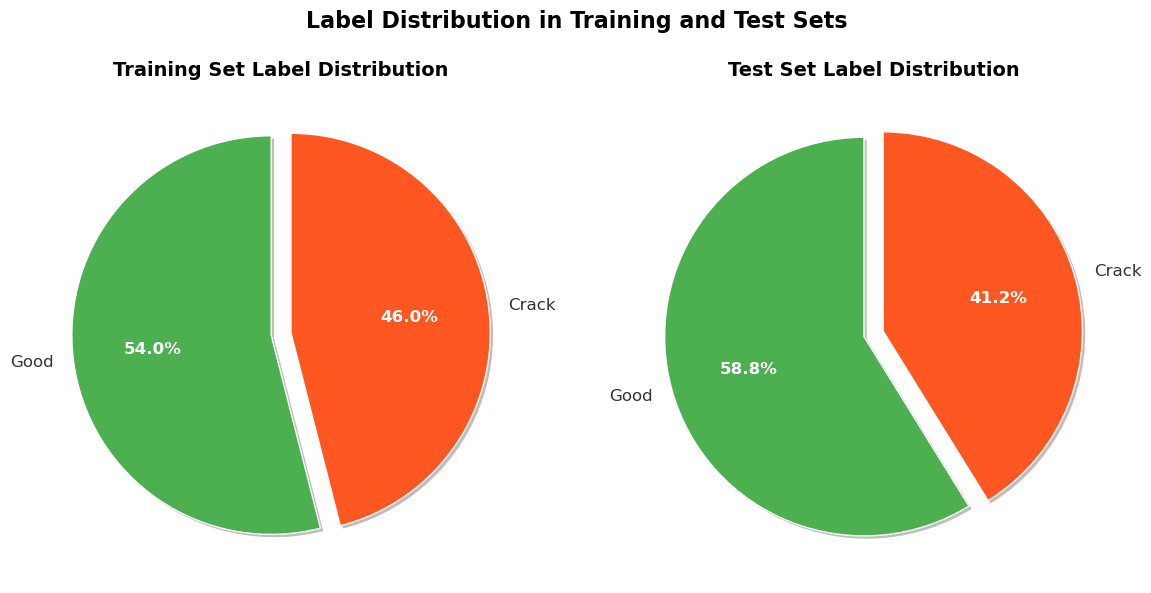

In [8]:
visualize_label_distribution(y_train, y_test)

### 2.3. Visualize Sample Images

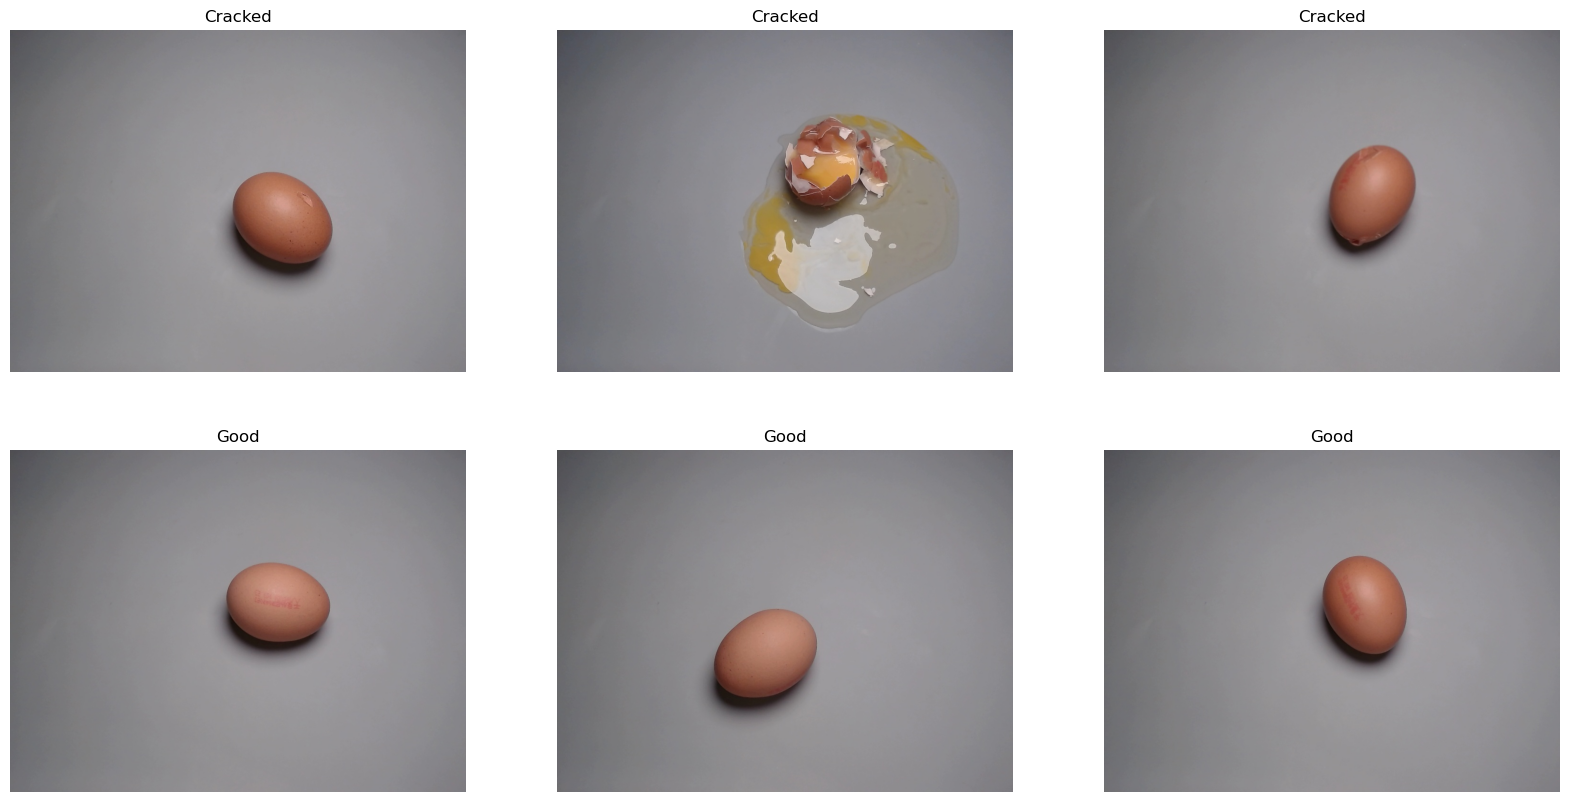

In [9]:
visualize_images(X_train, y_train)

### 2.4. Preprocess Images

In [10]:
# Process all images in the directory
X_train_preprocessed = np.array([preprocess_image(img) for img in X_train])
X_test_preprocessed = np.array([preprocess_image(img) for img in X_test])

### 2.5. Display Preprocessed Image

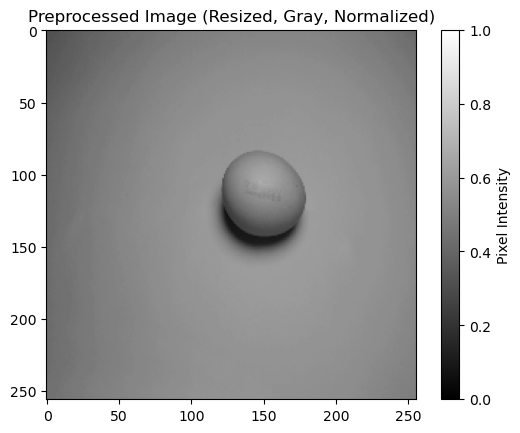

In [11]:
plt.imshow(X_train_preprocessed[0], cmap='gray', vmin=0, vmax=1)
plt.colorbar(label='Pixel Intensity')
plt.title('Preprocessed Image (Resized, Gray, Normalized)')
plt.show()

### 2.6. Flatten Images

In [12]:
X_train_flatten = X_train_preprocessed.reshape(X_train.shape[0], -1)
X_test_flatten = X_test_preprocessed.reshape(X_test.shape[0], -1)

# Print the dimensions of the flattened images
print(f"Dimensions of flattened training images: {X_train_flatten.shape}")
print(f"Dimensions of flattened test images: {X_test_flatten.shape}")

Dimensions of flattened training images: (352, 65536)
Dimensions of flattened test images: (17, 65536)


### 2.7 Canny Edge Detector

In [13]:
def canny_img(img, low_threshold=60, high_threshold=120):
    # Apply Canny edge detection
    edges = cv2.Canny(img, low_threshold, high_threshold)
    return edges

In [14]:
X_train_canny = np.array([canny_img(img) for img in X_train])
X_test_canny = np.array([canny_img(img) for img in X_test])

### 2.8 Comparation - Original, Processed Image and Canny Image

Text(0.5, 1.0, 'Canny Image')

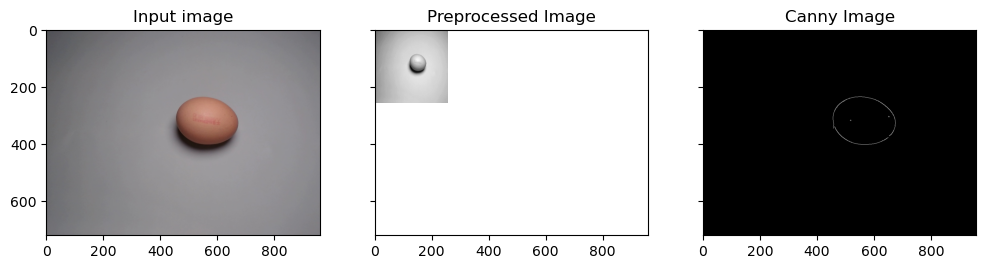

In [78]:
# display the image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

ax1.imshow(cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.imshow(X_train_preprocessed[0], cmap="gray")
ax2.set_title('Preprocessed Image')

# canny_image_rescaled = cv2.resize(X_train_canny[0], (256, 256))
ax3.imshow(X_train_canny[0], cmap=plt.cm.gray)
ax3.set_title('Canny Image')

## 3. Model Training and Evaluation
We use multiple models to evaluate their performance on the dataset:
1. **Dummy Classifier**: A baseline classifier using simple rules for prediction.
2. **KNN classifier**: A classifier that predicts based on the majority class of its k-nearest neighbors.
3. **Logistic Regression**: A linear model estimating probabilities for binary outcomes.
4. **Decision Tree Classifier**: A model that splits data based on feature values to form a tree structure.
5. **Random Forest**: An ensemble method that combines multiple decision trees to capture non-linear relationships and reduce overfitting.

### 3.1. Initialize Model Scores Dictionary

In [55]:
"""
Initialize a dictionary to store model scores
"""
models_scores_dict = {}

### 3.2. Dummy Classifier

In [56]:
"""
Train a dummy classifier and evaluate its performance
"""
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_flatten, y_train)
dummy_score = dummy_clf.score(X_test_flatten, y_test)
print(f"Dummy classifier score: {dummy_score:.4f}")
models_scores_dict["dummy"] = dummy_score

Dummy classifier score: 0.5882


### 3.3 K-Nearest Neighbors (KNN) Classifier

In [57]:
def knn(X_train, X_test, name=""):
    """
    Train a K-Nearest Neighbors (KNN) classifier and evaluate its performance
    """
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    knn_score = knn.score(X_test, y_test)
    print(f"KNN-{name} classifier score: {knn_score:.4f}")
    models_scores_dict[f"KNN {name}"] = knn_score

In [58]:
knn(X_train_flatten, X_test_flatten)

KNN- classifier score: 0.7059


#### Hyperparameter Tuning for K-Nearest Neighbors Classifier

In [43]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_neighbors': randint(1, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': randint(1, 5)  # Only used if metric is 'minkowski'
}

# Initialize RandomizedSearchCV with KNeighborsClassifier
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train_flatten, y_train)

# Print the best parameters from the RandomizedSearchCV
print("Best parameters from RandomizedSearch:", random_search.best_params_)

# Get the best estimator and evaluate it on the test data
best_model = random_search.best_estimator_
best_model_score = best_model.score(X_test_flatten, y_test)
print(f"Best model score on test set: {best_model_score:.4f}")

Best parameters from RandomizedSearch: {'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best model score on test set: 0.8824


### 3.4. Logistic Regression Classifier

In [59]:
def logistic_regression(X_train, X_test, name=""):
    """
    Train a Logistic Regression classifier and evaluate its performance
    """
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    lr_score = lr.score(X_test, y_test)
    print(f"Logistic Regression - {name} classifier score: {lr_score:.4f}")
    models_scores_dict[f"logistic regression {name}"] = lr_score

In [60]:
logistic_regression(X_train_flatten, X_test_flatten)

Logistic Regression -  classifier score: 0.8235


C:\Users\Alon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Hyperparameter Tuning for Logistic Regression Classifier

In [44]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_lr = {
    'C': uniform(0.01, 10),  # The inverse of regularization
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithm
    'max_iter': randint(50, 300)
}

# Initialize RandomizedSearchCV with LogisticRegression
random_search_lr = RandomizedSearchCV(LogisticRegression(), param_distributions=param_dist_lr, n_iter=100, cv=5, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV to the training data
random_search_lr.fit(X_train_flatten, y_train)

# Print the best parameters from the RandomizedSearchCV
print("Best parameters from RandomizedSearch for Logistic Regression:", random_search_lr.best_params_)

# Get the best estimator and evaluate it on the test data
best_model_lr = random_search_lr.best_estimator_
best_model_lr_score = best_model_lr.score(X_test_flatten, y_test)
print(f"Best Logistic Regression model score on test set: {best_model_lr_score:.4f}")

C:\Users\Alon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
210 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Alon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Alon\anaconda3\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Alon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

Best parameters from RandomizedSearch for Logistic Regression: {'C': 2.5516364906973874, 'max_iter': 283, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Logistic Regression model score on test set: 0.8824


C:\Users\Alon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 3.5. Decision Tree Classifier

In [61]:
def decision_tree(X_train, X_test, name=""):
    """
    Train a Decision Tree classifier and evaluate its performance
    """
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    dt_score = dt.score(X_test, y_test)
    print(f"Decision Tree - {name} classifier score: {dt_score:.4f}")
    models_scores_dict[f"decision tree {name}"] = dt_score

In [67]:
decision_tree(X_train_flatten, X_test_flatten)

Decision Tree -  classifier score: 0.8824


#### Hyperparameter Tuning for Decision Tree Classifier

In [33]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

# Initialize RandomizedSearchCV with DecisionTreeClassifier
random_search_dt = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_dist_dt, n_iter=100, cv=5, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV to the training data
random_search_dt.fit(X_train_flatten, y_train)

# Print the best parameters from the RandomizedSearchCV
print("Best parameters from RandomizedSearch for Decision Tree:", random_search_dt.best_params_)

# Get the best estimator and evaluate it on the test data
best_model_dt = random_search_dt.best_estimator_
best_model_dt_score = best_model_dt.score(X_test_flatten, y_test)
print(f"Best Decision Tree model score on test set: {best_model_dt_score:.4f}")

Best parameters from RandomizedSearch for Decision Tree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 17, 'min_samples_split': 3, 'splitter': 'best'}
Best Decision Tree model score on test set: 0.8235


### 3.6. Random Forest Classifier

In [63]:
def random_forest(X_train, X_test, name=""):
    """
    Train a Random Forest classifier and evaluate its performance
    """
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    rf_score = rf.score(X_test, y_test)
    print(f"Random Forest - {name} classifier score: {rf_score:.4f}")
    models_scores_dict[f"random forest {name}"] = rf_score

In [64]:
random_forest(X_train_flatten, X_test_flatten)

Random Forest -  classifier score: 0.9412


#### Hyperparameter Tuning for Random Forest Classifier

In [35]:
"""
Perform hyperparameter tuning using RandomizedSearchCV
"""

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 5, 10],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

# Initialize RandomizedSearchCV with RandomForestClassifier
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train_flatten, y_train)

# Print the best parameters from the RandomizedSearchCV
print("Best parameters from RandomizedSearch:", random_search.best_params_)

# Get the best estimator and evaluate it on the test data
best_model = random_search.best_estimator_
best_model_score = best_model.score(X_test_flatten, y_test)
print(f"Best model score on test set: {best_model_score:.4f}")

Best parameters from RandomizedSearch: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 111}
Best model score on test set: 0.8824


## 4. Models Scores Analysis

### 4.1 Print Scores

In [68]:
for model_name in models_scores_dict:
    print(f"model {model_name} score: {models_scores_dict[model_name]}")

model dummy score: 0.5882352941176471
model KNN  score: 0.7058823529411765
model logistic regression  score: 0.8235294117647058
model decision tree  score: 0.8823529411764706
model random forest  score: 0.9411764705882353


### 4.2 Visualize Original Models Scores

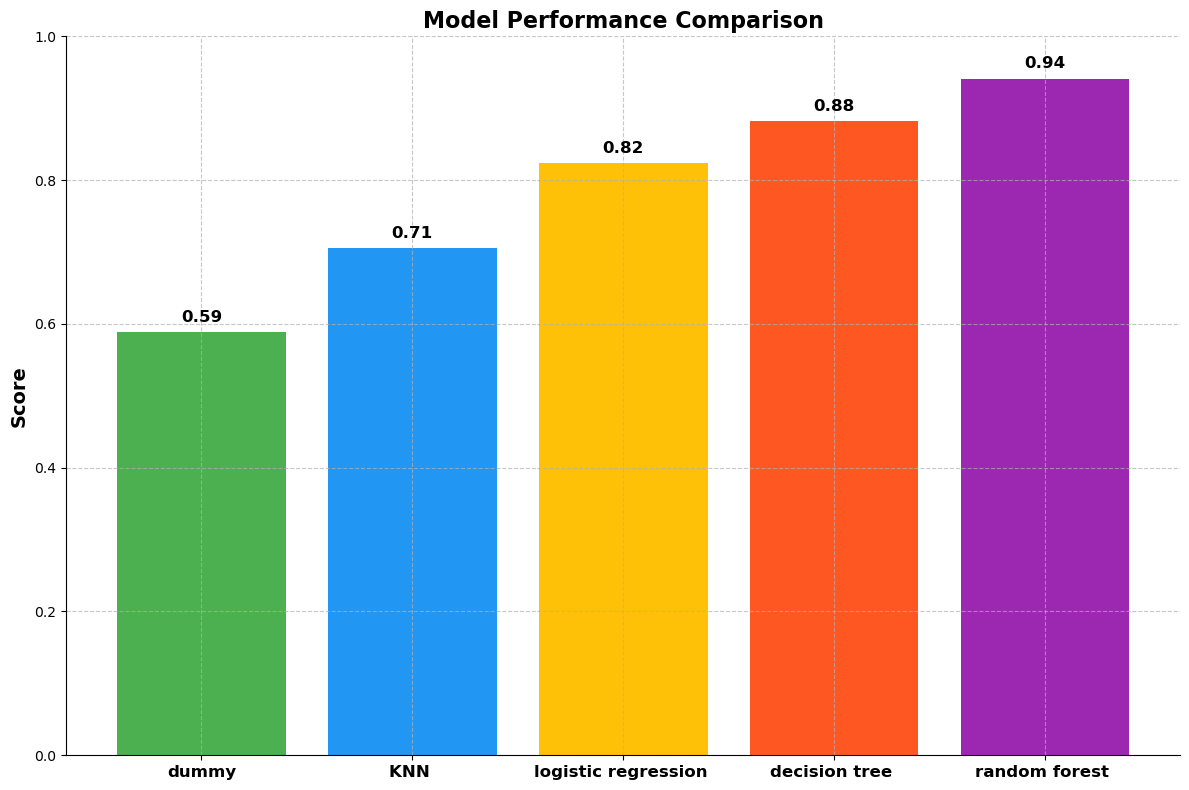

In [69]:
# Extract model names and scores
model_names = list(models_scores_dict.keys())
scores = list(models_scores_dict.values())

# Sort the models by score in ascending order
sorted_indices = sorted(range(len(scores)), key=lambda k: scores[k])
model_names = [model_names[i] for i in sorted_indices]
scores = [scores[i] for i in sorted_indices]

# Plotting the scores
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

bars = ax.bar(model_names, scores, color=['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0'])

# Adding data labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
            f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Styling the plot
ax.set_ylim(0, 1)
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, fontsize=12, fontweight='bold')

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### 4.3 Visualize Hypertuned Models Scores
We tuned the four models using RandomizedSearch to find better parameters for higher performance. Only KNN (0.8824) and Logistic Regression (0.8824) showed improvement. The Decision Tree and Random Forest did not improve, likely because we used RandomizedSearch instead of GridSearch.

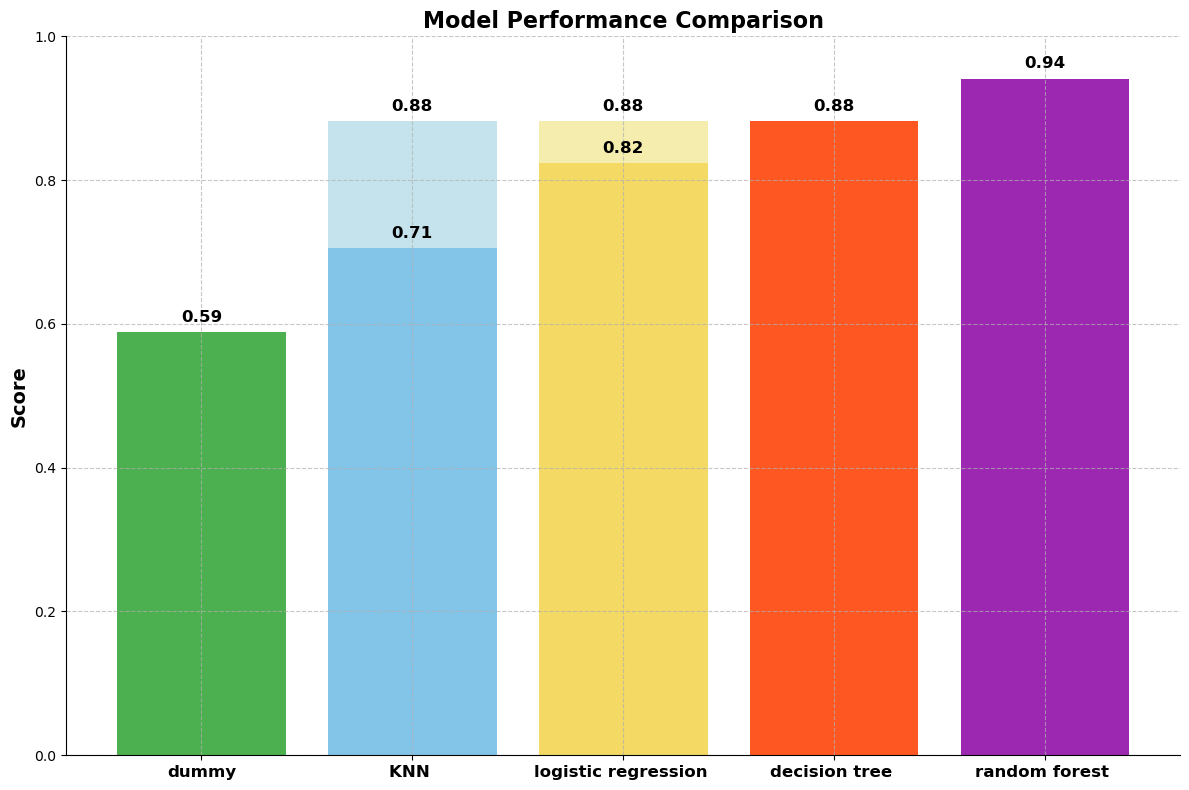

In [75]:
# Extract model names and scores
model_names = list(models_scores_dict.keys())
scores = list(models_scores_dict.values())

# Improved scores for KNN and Logistic Regression
improved_scores = {
    'KNN ': 0.8824,
    'logistic regression ': 0.8824
}

# Sort the models by score in ascending order
sorted_indices = sorted(range(len(scores)), key=lambda k: scores[k])
model_names = [model_names[i] for i in sorted_indices]
scores = [scores[i] for i in sorted_indices]

# Plotting the scores
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

bars = ax.bar(model_names, scores, color=['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0'])

# Adding data labels and improved scores
for bar in bars:
    height = bar.get_height()
    model_name = bar.get_x() + bar.get_width() / 2
    ax.text(model_name, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Check if the model has an improved score
    if model_names[int(bar.get_x() + 0.5)] in improved_scores:
        improved_score = improved_scores[model_names[int(bar.get_x() + 0.5)]]
        ax.bar(model_names[int(bar.get_x() + 0.5)], improved_score, color='khaki' if model_names[int(bar.get_x() + 0.5)] == 'logistic regression ' else 'lightblue', alpha=0.7)
        ax.text(model_name, improved_score + 0.01, f'{improved_score:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Styling the plot
ax.set_ylim(0, 1)
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, fontsize=12, fontweight='bold')

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 5. Using Canny Edge Detector Algorithm and Running the Models

### 5.1 Functions Definitions

In [76]:
def get_flatten_canny(t1, t2):
    """
    Applies the Canny edge detection algorithm to each image in the training and test datasets,
    flattens the resulting images, and returns the flattened arrays.

    Parameters:
    t1 (int or float): The first threshold for the hysteresis procedure in the Canny algorithm.
    t2 (int or float): The second threshold for the hysteresis procedure in the Canny algorithm.

    Returns:
    tuple: A tuple containing two numpy arrays:
        - X_train_canny_flatten (numpy array): The flattened Canny edge detected images for the training set.
        - X_test_canny_flatten (numpy array): The flattened Canny edge detected images for the test set.
    """
    X_train_canny = np.array([canny_img(img, t1, t2) for img in X_train])
    X_test_canny = np.array([canny_img(img, t1, t2) for img in X_test])
    
    X_train_canny_flatten = X_train_canny.reshape(X_train_canny.shape[0], -1)
    X_test_canny_flatten = X_test_canny.reshape(X_test_canny.shape[0], -1)
    
    return X_train_canny_flatten, X_test_canny_flatten

def apply_models(X_train_canny_flatten, X_test_canny_flatten):
    """
    Applies multiple machine learning models (KNN, Logistic Regression, Decision Tree, Random Forest)
    to the flattened Canny edge detected images and prints the results.

    Parameters:
    X_train_canny_flatten (numpy array): The flattened Canny edge detected images for the training set.
    X_test_canny_flatten (numpy array): The flattened Canny edge detected images for the test set.
    """
    knn(X_train_canny_flatten, X_test_canny_flatten, "canny")
    logistic_regression(X_train_canny_flatten, X_test_canny_flatten, "canny")
    decision_tree(X_train_canny_flatten, X_test_canny_flatten, "canny")
    random_forest(X_train_canny_flatten, X_test_canny_flatten, "canny")
    
def find_best_parameters(parameter_sets):
    """
    Iterates over a set of parameter combinations, applies the Canny edge detection with those parameters,
    and evaluates multiple machine learning models on the resulting data.

    Parameters:
    parameter_sets (list of tuples): A list of tuples where each tuple contains two values (t1, t2)
                                      representing the parameters for the Canny edge detection algorithm.
    """
    for t1, t2 in parameter_sets:
        x_train, x_test = get_flatten_canny(t1, t2)
        print(f"For parameters {t1}, {t2} we got:")
        apply_models(x_train, x_test)
        print("=" * 40)

### 5.2 Finding Best Paramaters (t1, t2) for Canny Algorithm

In [77]:
parameter_sets = [(40, 80), (50, 100), (45, 90), (35, 70), (50, 60), (30, 60), (55, 110), (80, 120)]
find_best_parameters(parameter_sets)

For parameters 40, 80 we got:
KNN-canny classifier score: 0.5882
Logistic Regression - canny classifier score: 0.7647
Decision Tree - canny classifier score: 0.9412
Random Forest - canny classifier score: 0.9412
For parameters 50, 100 we got:
KNN-canny classifier score: 0.5882
Logistic Regression - canny classifier score: 0.7059
Decision Tree - canny classifier score: 0.9412
Random Forest - canny classifier score: 0.8824
For parameters 45, 90 we got:
KNN-canny classifier score: 0.5882
Logistic Regression - canny classifier score: 0.7059
Decision Tree - canny classifier score: 0.9412
Random Forest - canny classifier score: 0.9412
For parameters 35, 70 we got:
KNN-canny classifier score: 0.5882
Logistic Regression - canny classifier score: 0.7059
Decision Tree - canny classifier score: 0.7647
Random Forest - canny classifier score: 0.9412
For parameters 50, 60 we got:
KNN-canny classifier score: 0.5882
Logistic Regression - canny classifier score: 0.7647
Decision Tree - canny classifier 